## LVV-T2112: Report

In [1]:
from astropy.time import Time, TimeDelta
from matplotlib import pylab as plt
import numpy

from lsst_efd_client import EfdClient

Define the various states the MTM1M3 subsystem can be in.

In [2]:
DISABLED = 1
ENABLED = 2
FAULT = 3
OFFLINE = 4
STANDBY = 5

Connnect to the EFD at the summit.

In [3]:
efd = EfdClient('summit_efd')

Read in the data from the log file.

In [4]:
summit_vals = numpy.genfromtxt('summit_M1M3_forceActuatorData.log', names=True, dtype=None, delimiter=',')

### Define the time window and define known gaps in the telemetry
The time window was chosen using the beginning of the our logging information.
We then simply select the 5 days after that.

In [5]:
t1 = Time(summit_vals['private_sndStamp'][0], format='unix', scale='tai')
t2 = t1 + TimeDelta(5*24*3600, format='sec')

In [6]:
print(t1.isot, '--', t2.isot)

2021-05-24T21:43:31.853 -- 2021-05-29T21:43:31.853


Now define the gaps in the data.
Most of the gaps can be detected by just inspecting what state the system was in for any given message (see three cells down from here).
There were two instances where the log was interrupted in ways that could not be automatically detected.
These two cases are described in the cell below.

In [7]:
# gaps here are manually added because something went wrong and the gap didn't show up in the summary state
gaps = [(Time('2021-05-25T13:17', format='isot', scale='tai'), Time('2021-05-25T14:40', format='isot', scale='tai')),  # There was a hard crash that did not send the CSC into FAULT
        (Time('2021-05-26T21:18', format='isot', scale='tai'), Time('2021-05-26T22:02', format='isot', scale='tai'))]  # This is because my pod went down due to planned maitenance

In [8]:
states = await efd.select_time_series('lsst.sal.MTM1M3.logevent_summaryState', 'summaryState', t1, t2)

In [9]:
prev = None

for row in states.iterrows():
    if row[1]['summaryState'] == ENABLED and (prev is None or prev == ENABLED):
        prev = row[1]['summaryState']
        continue
    elif not row[1]['summaryState'] == ENABLED and prev == ENABLED:
        prev = row[1]['summaryState']
        gap_begin = row[0]
    elif not row[1]['summaryState'] == ENABLED and not prev == ENABLED:
        prev = row[1]['summaryState']
        continue
    elif row[1]['summaryState'] == ENABLED and not prev == ENABLED:
        prev = row[1]['summaryState']
        gaps.append((Time(gap_begin, scale='tai'), Time(row[0], scale='tai')))
    else:
        print('We really should not get here')

In some rare cases, the client query can come at a time when the fields have not been fully populated.
In those instances, the missing fields are returned as NaNs.
We clip out these cases since they don't have enough information to compute a latency.

In [10]:
idx = numpy.isfinite(summit_vals['private_sndStamp']) & numpy.isfinite(summit_vals['now_after_query']) & numpy.isfinite(summit_vals['private_seqNum']) & numpy.isfinite(summit_vals['private_kafkaStamp'])

### Results
First, filter the data for the known gaps and compute the difference between the machine time and the `private_sndStamp`.

In [11]:
diff = []
dates = []
last_seq = None
for a, b, s in zip(summit_vals['now_after_query'][idx], summit_vals['private_sndStamp'][idx], summit_vals['private_seqNum'][idx]):
    # Skip if we already saw this message.
    # This avoids double counting messages with latency hihger than my sampling rate
    # For the sample selected from the first 5 days of the run, this trims out about 400 samples
    if s == last_seq:
        continue
    d = a - b + 37  # The machine time is in UTC, but the sndStamp is in TAI
    date = Time(b, format='unix', scale='tai')
    in_gap = False
    for gap in gaps:
        if date > gap[0] and date < gap[1]:
            in_gap = True
    if not in_gap and date > t1 and date < t2:
        dates.append(date.datetime)
        diff.append(d)
    last_seq = s

Plot the results.

In [12]:
def running_mean(x, N):
    cumsum = numpy.cumsum(numpy.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

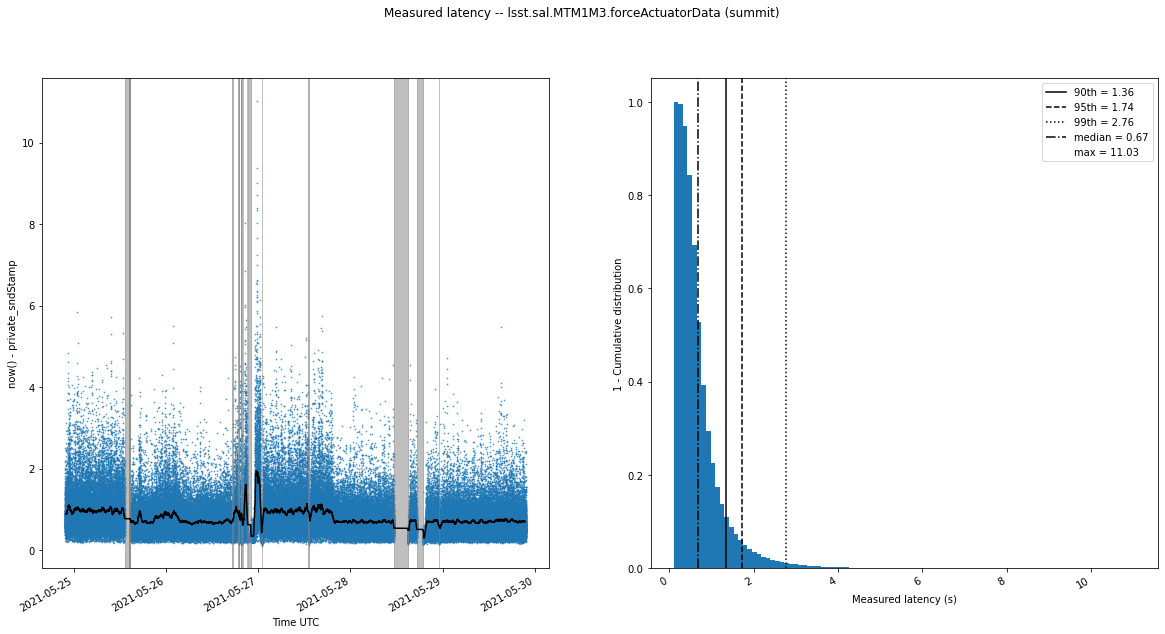

In [13]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
_ = fig.suptitle('Measured latency -- lsst.sal.MTM1M3.forceActuatorData (summit)')
scat = ax0.scatter(dates, diff, alpha=0.7, s=0.5)
xl0 = ax0.set_xlabel('Time UTC')
yl0 = ax0.set_ylabel('now() - private_sndStamp')
rm = ax0.plot(dates[499:-500], running_mean(diff, 1000), c='black')
hist = ax1.hist(diff, cumulative=-1, bins=100, density=True)
yl1 = ax1.set_ylabel('1 - Cumulative distribution')
xl1 = ax1.set_xlabel('Measured latency (s)')

for gap in gaps:
    ax0.axvspan(gap[0].datetime, gap[1].datetime, alpha=0.5, color='grey')
vl = ax1.axvline(numpy.percentile(diff, 90), c='black', ls='solid', label=f'90th = {numpy.percentile(diff, 90):.2f}')
v2 = ax1.axvline(numpy.percentile(diff, 95), c='black', ls='dashed', label=f'95th = {numpy.percentile(diff, 95):.2f}')
v3 = ax1.axvline(numpy.percentile(diff, 99), c='black', ls='dotted', label=f'99th = {numpy.percentile(diff, 99):.2f}')
v4 = ax1.axvline(numpy.median(diff), c='black', ls='dashdot', label=f'median = {numpy.median(diff):.2f}')
v4 = ax1.axvline(6, c='black', ls='dashdot', alpha=0.0, label=f'max = {numpy.max(diff):.2f}')
leg = ax1.legend()
plt.gcf().autofmt_xdate()

The plots above show the latency as a function of time on the left, and the distribution of those latencies on the right.
We show that the 99th percentile is well below the 4 second threshold.
As shown in the cells below, 4 seconds equates to the 99.8th percentile.

In [14]:
idx = numpy.where(numpy.array(diff) > 4)

In [15]:
print(1 - len(idx[0])/len(diff))

0.9984157507156436


### Low latency investigation
We have shown that the high frequency topic we chose fits within the parameters specified in the test plan.
We now need to show the same for a lower latency topic in the same subsystem to show that the high frequency topic is not keeping up by strangling the lower frequency ones.

We choose the very same time window as for the high frequency topic.
For the low frequency topic, we choose "lsst.sal.MTM1M3.logevent_heartbeat" which logs a message every ~1 second with minimal content.

In [16]:
heartbeat_vals = numpy.genfromtxt('summit_M1M3_heartbeat.log', names=True, dtype=None, delimiter=',')

Once again we remove entries where the query retrieved data before it was fully consistent in the database.

In [17]:
idx = numpy.isfinite(heartbeat_vals['private_sndStamp']) & numpy.isfinite(heartbeat_vals['now_after_query']) & numpy.isfinite(heartbeat_vals['private_seqNum']) & numpy.isfinite(heartbeat_vals['private_kafkaStamp'])

Apply the gap cuts and compute the latencies.

In [18]:
diff = []
dates = []
last_seq = None
for a, b, s in zip(heartbeat_vals['now_after_query'][idx], heartbeat_vals['private_sndStamp'][idx], heartbeat_vals['private_seqNum'][idx]):
    # Skip if we already saw this message.
    # This avoids double counting messages with latency hihger than my sampling rate
    # For the sample selected from the first 5 days of the run, this trims out about 400 samples
    if s == last_seq:
        continue
    d = a - b + 37  # The machine time is in UTC, but the sndStamp is in TAI
    date = Time(b, format='unix', scale='tai')
    in_gap = False
    for gap in gaps:
        if date > gap[0] and date < gap[1]:
            in_gap = True
    if not in_gap and date > t1 and date < t2:
        dates.append(date.datetime)
        diff.append(d)
    last_seq = s

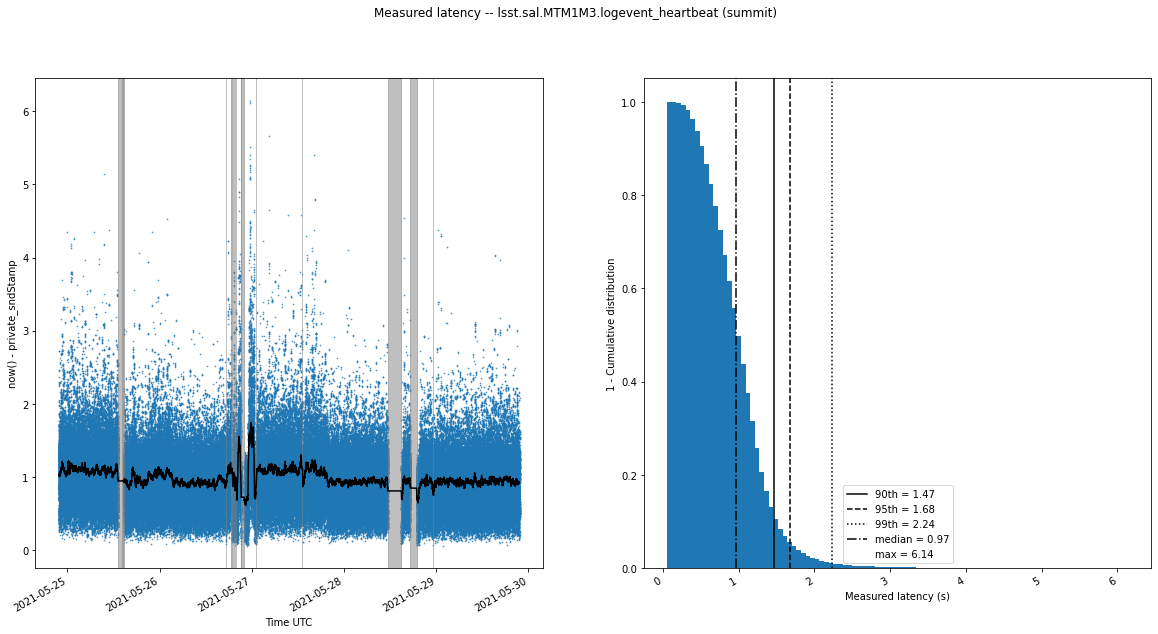

In [19]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
_ = fig.suptitle('Measured latency -- lsst.sal.MTM1M3.logevent_heartbeat (summit)')
scat = ax0.scatter(dates, diff, alpha=0.7, s=0.5)
xl0 = ax0.set_xlabel('Time UTC')
yl0 = ax0.set_ylabel('now() - private_sndStamp')
rm = ax0.plot(dates[499:-500], running_mean(diff, 1000), c='black')
hist = ax1.hist(diff, cumulative=-1, bins=100, density=True)
yl1 = ax1.set_ylabel('1 - Cumulative distribution')
xl1 = ax1.set_xlabel('Measured latency (s)')

for gap in gaps:
    ax0.axvspan(gap[0].datetime, gap[1].datetime, alpha=0.5, color='grey')
vl = ax1.axvline(numpy.percentile(diff, 90), c='black', ls='solid', label=f'90th = {numpy.percentile(diff, 90):.2f}')
v2 = ax1.axvline(numpy.percentile(diff, 95), c='black', ls='dashed', label=f'95th = {numpy.percentile(diff, 95):.2f}')
v3 = ax1.axvline(numpy.percentile(diff, 99), c='black', ls='dotted', label=f'99th = {numpy.percentile(diff, 99):.2f}')
v4 = ax1.axvline(numpy.median(diff), c='black', ls='dashdot', label=f'median = {numpy.median(diff):.2f}')
v4 = ax1.axvline(6, c='black', ls='dashdot', alpha=0.0, label=f'max = {numpy.max(diff):.2f}')
leg = ax1.legend()
plt.gcf().autofmt_xdate()

This is the same plot as for the high frequency plot, but for the low frequency topic chosen here.
The 99th percentile is well within the 4 second envelope.

As shown below, 4 seconds corresponds to the 99.975th percentile.

Note that the median is ~1 second.
This is due to the fact that the topic publishes at 1 second, but the polling script also queried at ~1 second.
This implies that the uncertainty on the measured latency is up to a second.

In [20]:
idx = numpy.where(numpy.array(diff) > 4)
print(1 - len(idx[0])/len(diff))

0.999754179636683
